# NIR Behavioral Pipeline — Complete Reference

This notebook contains **every step** of the NIR behavioral pipeline in a single document, from raw HDF5 data to final behavioral metrics and plots.

### Pipeline Overview

```
┌──────────────────────────────────────────────────────────────┐
│  Part 0 │ Environment Setup                                 │
│         │ Julia 1.8.2 + depot  │  Python conda env          │
├─────────┼────────────────────────────────────────────────────┤
│  Part 1 │ Data Inspection (Python)                          │
│         │ • HDF5 structure, DAQ signals, sample NIR frames  │
├─────────┼────────────────────────────────────────────────────┤
│  Part 2 │ Compute Worm Spline (Julia)                       │
│         │ • UNet segmentation → medial axis → spline        │
│         │ • Two-pass: initial + thickness correction         │
│         │ → Saves data_dict.jld2                            │
├─────────┼────────────────────────────────────────────────────┤
│  Part 3 │ NIR–Confocal Synchronization (Python)             │
│         │ • Peak detection on piezo → confocal volume times  │
│         │ • Filter NIR triggers → saved frame times         │
│         │ → Exports aligned NIR .tif, stage .csv, .npz      │
├─────────┼────────────────────────────────────────────────────┤
│  Part 4 │ Compute Behavioral Metrics (Julia)                │
│         │ • Body angles, angular velocity, velocity/speed   │
│         │ • Curvature, nose curling, reversals              │
│         │ → Updates data_dict.jld2                          │
├─────────┼────────────────────────────────────────────────────┤
│  Part 5 │ Visualization & Export (Python)                   │
│         │ • Behavioral metric plots, trajectory, video      │
├─────────┼────────────────────────────────────────────────────┤
│ Append. │ Behavioral Metrics Reference                      │
│         │ • Full mathematical definitions, units, shapes    │
└──────────────────────────────────────────────────────────────┘
```

### Language Setup

This notebook uses a **Python kernel** for all Python code cells (Parts 1, 3, 5).  
Julia code (Parts 2, 4) is provided in markdown blocks — copy and run it in a **Julia 1.8.2 REPL** or a separate Julia-kernel notebook.

| Part | Language | Kernel |
|------|----------|--------|
| 0 | — | Setup instructions only |
| 1 | **Python** | `g5ht-pipeline` or `nir-pipeline` conda env |
| 2 | **Julia** | Julia 1.8.2 with `~/.julia-flv` depot |
| 3 | **Python** | `g5ht-pipeline` or `nir-pipeline` conda env |
| 4 | **Julia** | Julia 1.8.2 with `~/.julia-flv` depot |
| 5 | **Python** | `g5ht-pipeline` or `nir-pipeline` conda env |

---
## Part 0: Environment Setup

### 0A. Julia 1.8.2

The Flavell lab packages require **Julia 1.8.2** specifically.  
Download: https://julialang.org/downloads/oldreleases/

#### Set up a dedicated Julia depot (to avoid conflicts)

**Windows (PowerShell):**
```powershell
# Permanent
setx JULIA_DEPOT_PATH "$env:USERPROFILE\.julia-flv"
# Current session
$env:JULIA_DEPOT_PATH = "$env:USERPROFILE\.julia-flv"
```

**Linux:**
```bash
echo 'export JULIA_DEPOT_PATH="$HOME/.julia-flv"' >> ~/.bashrc && source ~/.bashrc
```

#### Install Julia packages

Launch Julia 1.8.2 and run:

```julia
import Pkg

# --- PyCall (uses its own internal conda) ---
ENV["PYTHON"] = ""
Pkg.add("PyCall")
Pkg.build("PyCall")
using PyCall; println(PyCall.python)  # Should print ~/.julia-flv/conda/3/.../python.exe

# --- Standard packages ---
Pkg.add(["HDF5", "H5Zblosc", "JLD2", "FileIO", "PyPlot",
         "Statistics", "CSV", "DataFrames"])

# --- Flavell Lab packages (requires GitHub SSH access to flavell-lab) ---
ENV["JULIA_SSL_CA_ROOTS_PATH"] = ""
Pkg.add(url="https://github.com/flavell-lab/FlavellPkg.jl.git")
using FlavellPkg
install_default()
install_behavior()
# install_ANTSUN()   # optional
# install_CEPNEM()   # optional

# --- OR install individually ---
# Pkg.add(url="git@github.com:flavell-lab/ImageDataIO.jl.git")
# Pkg.add(url="git@github.com:flavell-lab/BehaviorDataNIR.jl.git")
# Pkg.add(url="git@github.com:flavell-lab/UNet2D.jl.git")
```

#### Verify Julia installation

```julia
using ImageDataIO, BehaviorDataNIR, UNet2D, H5Zblosc
using HDF5, PyPlot, FileIO, JLD2, Statistics
println("All Julia packages loaded!")
```

---

### 0B. Python / Conda

```bash
conda create -n nir-pipeline python=3.10 -y
conda activate nir-pipeline
pip install --upgrade pip
pip install numpy h5py scipy matplotlib pandas tifffile
pip install scikit-image scikit-learn networkx
pip install imageio[ffmpeg] opencv-python

# GPU PyTorch (for UNet worm segmentation from Python)
# pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu129
pip install torch==2.8.0 torchvision==0.23.0 torchaudio==2.8.0 --index-url https://download.pytorch.org/whl/cu129

# Flavell lab Python packages
pip install git+ssh://git@github.com/flavell-lab/unet2d.git@v0.1
```

### 0C. Files checklist

| File | Description |
|------|-------------|
| `*.h5` | Raw HDF5 data file from microscope |
| `worm_segmentation_best_weights_0310.pt` | UNet2D weights (in `nir/` folder or lab shared drive) |
| `test.jl` | Helper functions for Julia behavioral pipeline (in `nir/` folder) |
| `sync_and_export.py` | Python sync functions (in `nir/` folder) |

---
## Part 1: Data Inspection (Python)

> **Kernel:** Python (`g5ht-pipeline` or `nir-pipeline`)

Before running any computation, inspect the HDF5 file to confirm it has the expected datasets and understand the raw signals.

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import os, sys

# ============================================================
# USER CONFIG — EDIT THESE
# ============================================================
PTH = r'C:\Users\munib\POSTDOC\DATA\g5ht-free\20251028'
FN  = 'date-20251028_time-1500_strain-ISg5HT_condition-starvedpatch_worm002'
h5_path = os.path.join(PTH, FN + '.h5')

# Expected number of confocal VOLUMES (timepoints), NOT z-slices
EXPECTED_N_VOLUMES = 751

print(f"File: {h5_path}")
print(f"Exists: {os.path.exists(h5_path)}")

File: C:\Users\munib\POSTDOC\DATA\g5ht-free\20251028\date-20251028_time-1500_strain-ISg5HT_condition-starvedpatch_worm002.h5
Exists: True


In [2]:
# ============================================================
# 1A. Print HDF5 structure
# ============================================================
with h5py.File(h5_path, 'r') as f:
    print(f"\nHDF5 file structure: {h5_path}\n")
    def visitor(name, obj):
        if isinstance(obj, h5py.Dataset):
            print(f"  {name:40s} shape={str(obj.shape):20s} dtype={obj.dtype}")
        elif isinstance(obj, h5py.Group):
            print(f"  {name}/  (group)")
    f.visititems(visitor)

    print("\n--- Key checks ---")
    for key in ['img_nir', 'daqmx_ai', 'daqmx_di', 'pos_stage']:
        if key in f:
            print(f"  {key}: {f[key].shape}")
        else:
            print(f"  WARNING: {key} NOT FOUND")
    if 'img_metadata' in f:
        for sub in f['img_metadata']:
            print(f"  img_metadata/{sub}: {f['img_metadata'][sub].shape}")


HDF5 file structure: C:\Users\munib\POSTDOC\DATA\g5ht-free\20251028\date-20251028_time-1500_strain-ISg5HT_condition-starvedpatch_worm002.h5

  daqmx_ai                                 shape=(3, 2029572)         dtype=float64
  daqmx_di                                 shape=(2, 2029588)         dtype=uint32
  img_metadata/  (group)
  img_metadata/img_id                      shape=(15948,)             dtype=int64
  img_metadata/img_timestamp               shape=(15948,)             dtype=int64
  img_metadata/q_iter_save                 shape=(15948,)             dtype=uint8
  img_metadata/q_recording                 shape=(15948,)             dtype=uint8
  img_nir                                  shape=(7974, 732, 968)     dtype=uint8
  pos_feature                              shape=(7974, 3, 3)         dtype=float32
  pos_stage                                shape=(7974, 2)            dtype=float64
  recording_start                          shape=()                   dtype=|S23

--- Ke

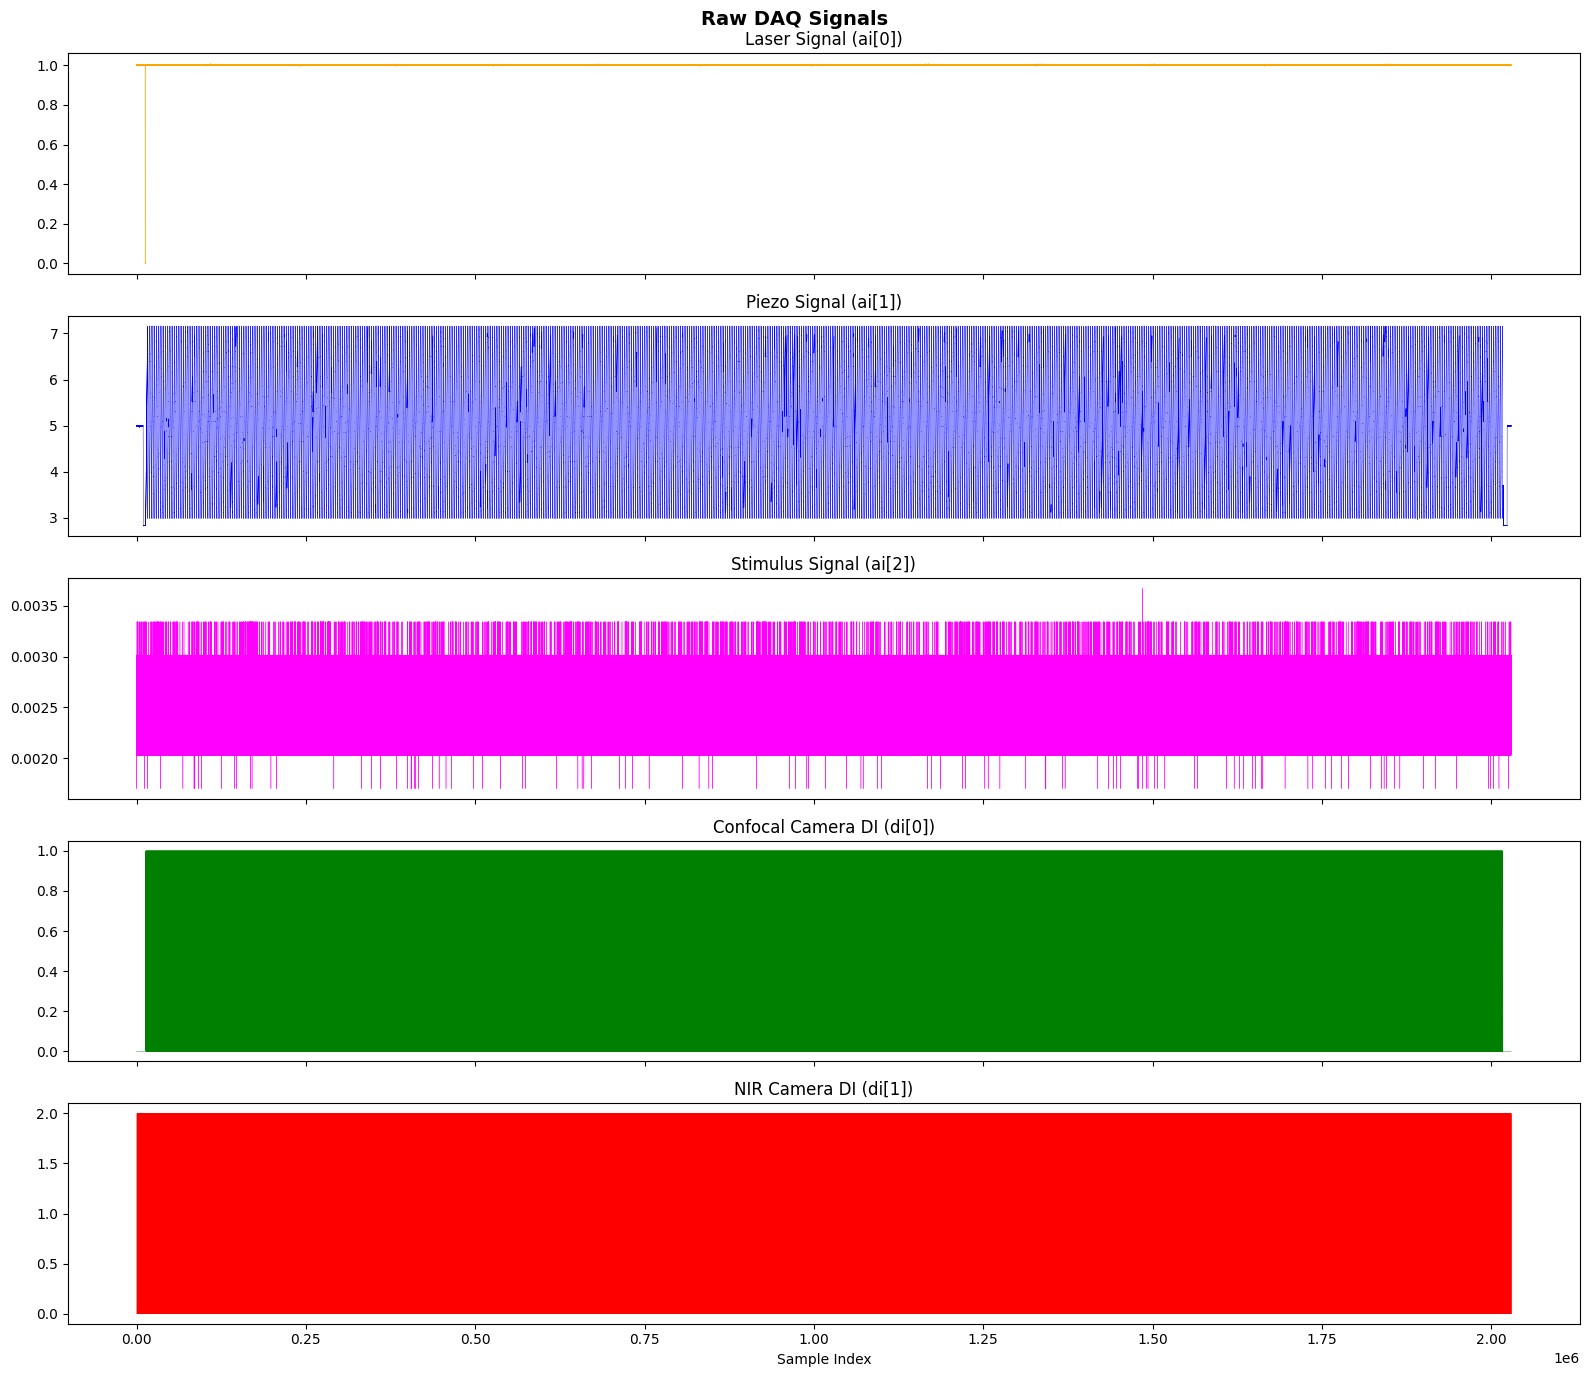

daqmx_ai shape: (3, 2029572)
daqmx_di shape: (2, 2029588)


In [3]:
# ============================================================
# 1B. Plot raw DAQ signals (used for synchronization)
# ============================================================
with h5py.File(h5_path, 'r') as f:
    daqmx_ai = f['daqmx_ai'][:]
    daqmx_di = f['daqmx_di'][:]

# Handle both (n_samples, n_channels) and (n_channels, n_samples) layouts
if daqmx_ai.shape[0] < daqmx_ai.shape[1]:
    ai = daqmx_ai   # (channels, samples)
else:
    ai = daqmx_ai.T  # transpose to (channels, samples)

if daqmx_di.shape[0] < daqmx_di.shape[1]:
    di = daqmx_di
else:
    di = daqmx_di.T

fig, axes = plt.subplots(5, 1, figsize=(16, 14), sharex=True)

labels = [
    ('Laser Signal (ai[0])',    'orange'),
    ('Piezo Signal (ai[1])',    'blue'),
    ('Stimulus Signal (ai[2])', 'magenta'),
    ('Confocal Camera DI (di[0])', 'green'),
    ('NIR Camera DI (di[1])',      'red'),
]

for i in range(3):
    axes[i].plot(ai[i], color=labels[i][1], linewidth=0.3)
    axes[i].set_title(labels[i][0])

for i in range(2):
    axes[i+3].plot(di[i], color=labels[i+3][1], linewidth=0.3)
    axes[i+3].set_title(labels[i+3][0])

axes[-1].set_xlabel('Sample Index')
plt.suptitle('Raw DAQ Signals', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"daqmx_ai shape: {daqmx_ai.shape}")
print(f"daqmx_di shape: {daqmx_di.shape}")

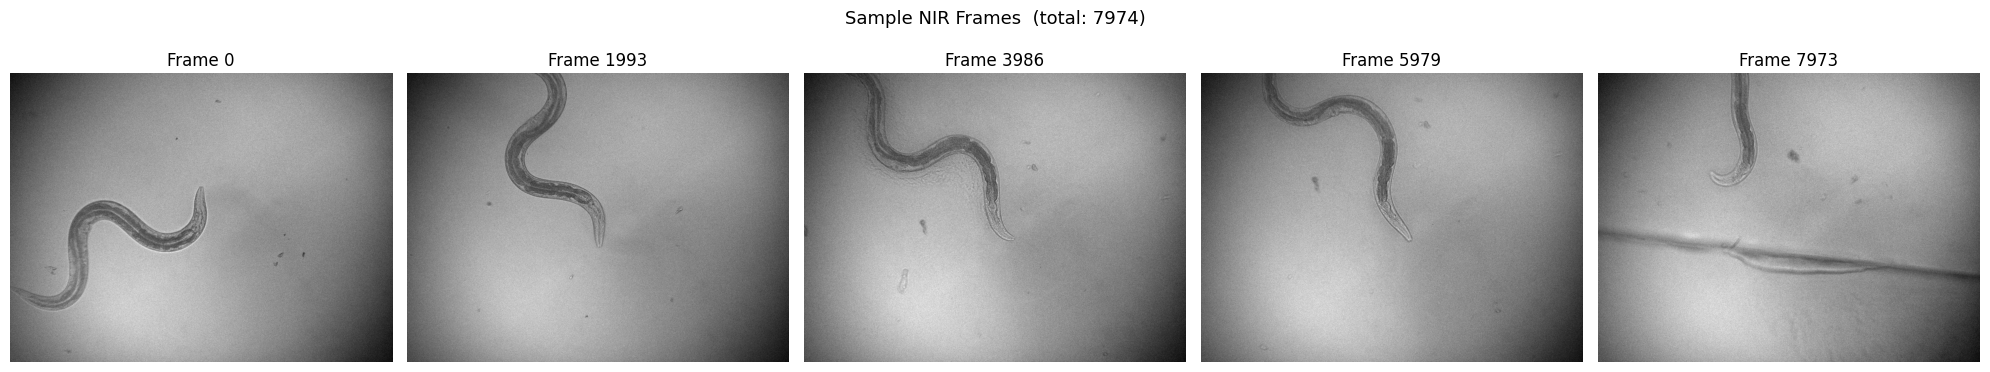

img_nir shape: (7974, 732, 968)


In [4]:
# ============================================================
# 1C. View sample NIR frames
# ============================================================
with h5py.File(h5_path, 'r') as f:
    nir_shape = f['img_nir'].shape
    n_frames = nir_shape[0] if nir_shape[0] > nir_shape[2] else nir_shape[2]

    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    idxs = np.linspace(0, n_frames - 1, 5, dtype=int)
    for ax, idx in zip(axes, idxs):
        # Handle both (frames, H, W) and (H, W, frames) layouts
        if nir_shape[0] > nir_shape[2]:
            frame = f['img_nir'][idx]
        else:
            frame = f['img_nir'][:, :, idx]
        ax.imshow(frame, cmap='gray')
        ax.set_title(f'Frame {idx}')
        ax.axis('off')
    plt.suptitle(f'Sample NIR Frames  (total: {n_frames})', fontsize=13)
    plt.tight_layout()
    plt.show()

print(f"img_nir shape: {nir_shape}")

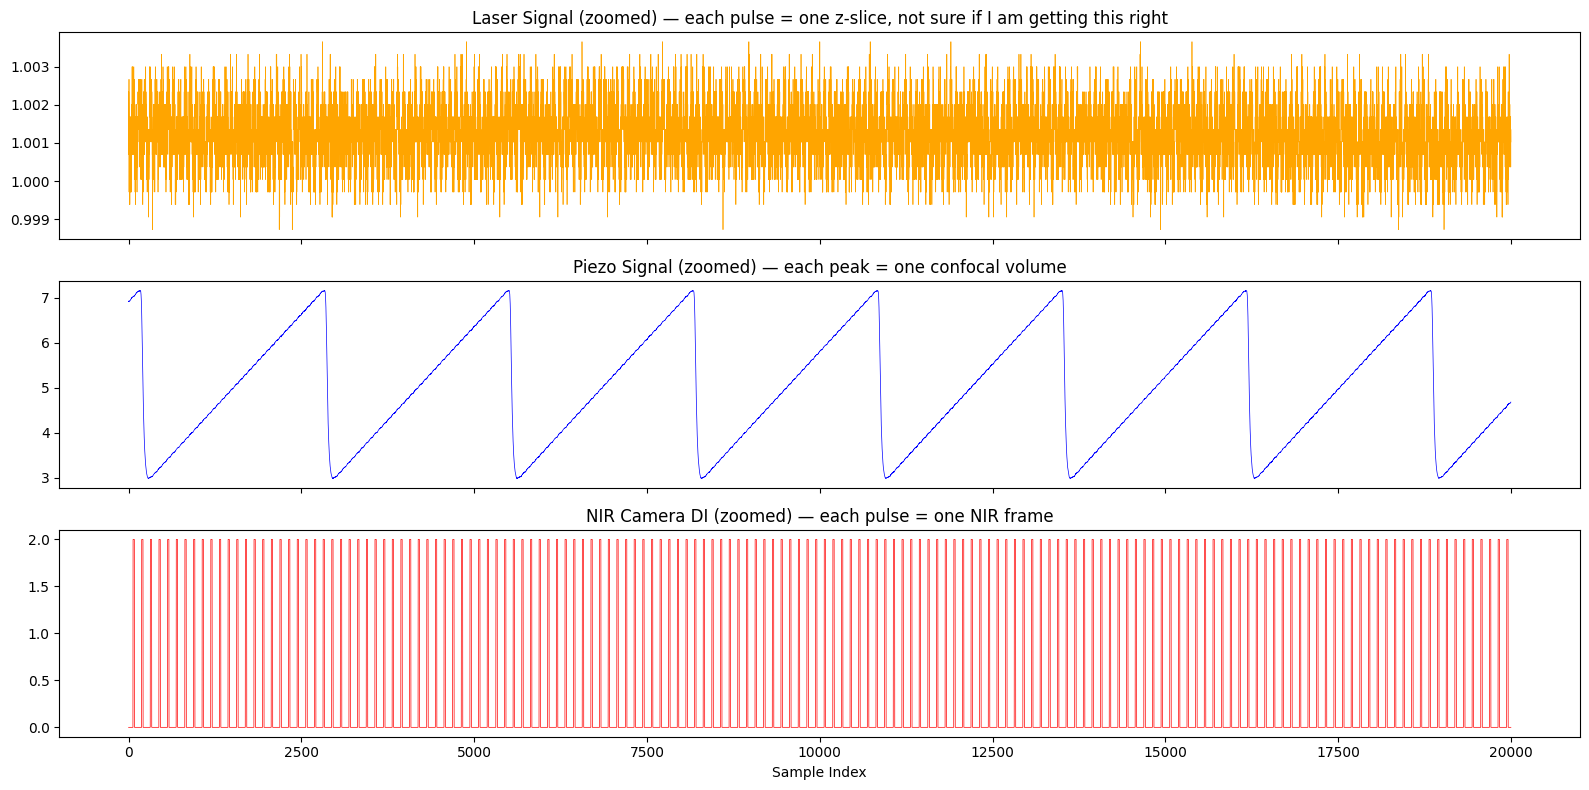

In [7]:
# ============================================================
# 1D. Zoomed DAQ signals — first 20,000 samples
# ============================================================
# zoom = 20000
zoom = (40000, 60000)

fig, axes = plt.subplots(3, 1, figsize=(16, 8), sharex=True)

axes[0].plot(ai[0, zoom[0]:zoom[1]], color='orange', linewidth=0.5)
axes[0].set_title('Laser Signal (zoomed) — each pulse = one z-slice, not sure if I am getting this right')

axes[1].plot(ai[1, zoom[0]:zoom[1]], color='blue', linewidth=0.5)
axes[1].set_title('Piezo Signal (zoomed) — each peak = one confocal volume')

axes[2].plot(di[1, zoom[0]:zoom[1]], color='red', linewidth=0.5)
axes[2].set_title('NIR Camera DI (zoomed) — each pulse = one NIR frame')

axes[-1].set_xlabel('Sample Index')
plt.tight_layout()
plt.show()

---
## Part 2: Compute Worm Spline (Julia)

> **Run in:** Julia 1.8.2 REPL or Julia-kernel notebook  
> **Time:** ~200 min (pass 1) + ~90 min (pass 2)  
> **Output:** `data_dict.jld2` containing spline coordinates for every NIR frame

The spline computation:
1. Segments the worm from each NIR frame using a **UNet2D** model
2. Computes the **medial axis** (skeleton) of the worm
3. Fits a smooth **spline** along the medial axis (1001 points, head→tail)
4. Detects **omega turns** and **self-intersections** using worm thickness
5. **Recomputes** the spline with thickness correction for higher accuracy

### 2A. PyCall Setup (Julia)

BehaviorDataNIR uses Python packages (scikit-image, scikit-learn, networkx) via PyCall.  
If these aren't installed in PyCall's internal conda, run:

```julia
# Option A: point PyCall at your conda env (if you have one with the right packages)
ENV["PYTHON"] = "C:\\Users\\munib\\miniconda3\\envs\\nir-pipeline\\python.exe"
import Pkg; Pkg.build("PyCall")
# Restart Julia after this!

# Option B: install into PyCall's internal conda
using Conda
Conda.add("scikit-image", channel="conda-forge")
Conda.add("scikit-learn", channel="conda-forge")
Conda.add("networkx")
```

### 2B. Config & Load Model

```julia
# ============================================================
# SETUP
# ============================================================
ENV["CUDA_VISIBLE_DEVICES"] = "0"   # set to "" for CPU-only

using ImageDataIO, BehaviorDataNIR, UNet2D, H5Zblosc
using HDF5, PyPlot, FileIO, JLD2

# ============================================================
# USER CONFIG — EDIT THESE
# ============================================================
NAME = "date-20251028_time-1500_strain-ISg5HT_condition-starvedpatch_worm002"
PATH_H5   = "C:\\Users\\munib\\POSTDOC\\DATA\\g5ht-free\\20251028\\$(NAME).h5"
PATH_JLD2 = "C:\\Users\\munib\\POSTDOC\\DATA\\g5ht-free\\20251028\\$(NAME)_data_dict.jld2"
path_weight = "C:\\Users\\munib\\POSTDOC\\CODE\\g5ht-pipeline\\nir\\worm_segmentation_best_weights_0310.pt"

# ============================================================
# GET FRAME COUNT
# ============================================================
MAX_T_NIR = size(h5open(PATH_H5)["img_nir"])[3]
println("Total NIR frames: $MAX_T_NIR")

# ============================================================
# ALGORITHM PARAMETERS (usually no need to change)
# ============================================================
param = Dict()
param["num_center_pts"]           = 1000
param["img_label_size"]           = (480, 360)
param["nose_confidence_threshold"] = 0.99
param["nose_crop_threshold"]      = 20
param["min_len_percent"]          = 90
param["max_len_percent"]          = 98
param["worm_thickness_pad"]       = 3
param["boundary_thickness"]       = 5
param["close_pts_threshold"]      = 30
param["trim_head_tail"]           = 15
param["max_med_axis_delta"]       = Inf

# ============================================================
# INITIALIZE DATA DICTIONARY
# ============================================================
data_dict = Dict()
data_dict["med_axis_dict"]    = Dict(0 => nothing)
data_dict["pts_order_dict"]   = Dict(0 => nothing)
data_dict["is_omega"]         = Dict()
data_dict["x_array"]          = zeros(MAX_T_NIR, param["num_center_pts"] + 1)
data_dict["y_array"]          = zeros(MAX_T_NIR, param["num_center_pts"] + 1)
data_dict["nir_worm_angle"]   = zeros(MAX_T_NIR)
data_dict["eccentricity"]     = zeros(MAX_T_NIR)
error_dict = Dict()

# ============================================================
# LOAD SEGMENTATION MODEL
# ============================================================
println("Loading UNet2D model...")
worm_seg_model = create_model(1, 1, 16, path_weight)
println("Model loaded!")
```

### 2C. Spline Computation (Pass 1 — ~200 minutes)

```julia
# Stage 1: Initial spline computation
println("Computing initial spline (pass 1)...")
error_dict["worm_spline_errors_1"] = compute_worm_spline!(
    param, PATH_H5, worm_seg_model, nothing,
    data_dict["med_axis_dict"], data_dict["pts_order_dict"],
    data_dict["is_omega"], data_dict["x_array"], data_dict["y_array"],
    data_dict["nir_worm_angle"], data_dict["eccentricity"]
)
println("Pass 1 complete. Errors: $(length(error_dict[\"worm_spline_errors_1\"]))")
```

### 2D. Thickness Detection + Spline Pass 2 (~90 minutes)

```julia
# Stage 2: Detect worm thickness for self-intersection handling
println("Detecting worm thickness...")
data_dict["worm_thickness"], count = compute_worm_thickness(
    param, PATH_H5, worm_seg_model,
    data_dict["med_axis_dict"], data_dict["is_omega"]
)
println("Thickness: $(data_dict[\"worm_thickness\"]) (from $count frames)")

# Stage 3: Recompute spline with thickness correction
println("Recomputing spline (pass 2)...")
error_dict["worm_spline_errors_2"] = compute_worm_spline!(
    param, PATH_H5, worm_seg_model, data_dict["worm_thickness"],
    data_dict["med_axis_dict"], data_dict["pts_order_dict"],
    data_dict["is_omega"], data_dict["x_array"], data_dict["y_array"],
    data_dict["nir_worm_angle"], data_dict["eccentricity"],
    timepts=1:MAX_T_NIR
)

# Save
println("Saving data_dict to: $PATH_JLD2")
save(PATH_JLD2, "data_dict", data_dict)
println("Done!")
```

### 2E. Post-Spline Quality Check Plots (Julia)

```julia
# Plot: splines from every 100th frame
using PyPlot
figure(figsize=(10, 8))
for i = 1:100:MAX_T_NIR
    plot(data_dict["x_array"][i, :], data_dict["y_array"][i, :])
end
title("Worm splines (every 100th frame)")
xlabel("x (pixels)"); ylabel("y (pixels)")

# Plot: worm angle + eccentricity over time
figure(figsize=(10, 4))
subplot(211)
plot(1:MAX_T_NIR, data_dict["nir_worm_angle"])
ylabel("Angle (rad)"); title("Worm body angle")
subplot(212)
plot(1:MAX_T_NIR, data_dict["eccentricity"])
ylabel("Eccentricity"); xlabel("Frame")
tight_layout()

# Plot: overlaid splines on NIR images (every 200th frame)
for i in 1:200:1000
    figure(figsize=(8, 6))
    f = h5open(PATH_H5)
    img_raw = f["img_nir"][:, :, i][1:2:end, 1:2:end]  # 2x downsample
    close(f)
    imshow(img_raw', cmap="gray")
    plot(data_dict["x_array"][i, :], data_dict["y_array"][i, :], color="red", linewidth=2)
    title("Frame $i")
end
```

### `data_dict` Keys After Spline Computation

| Key | Shape | Description |
|-----|-------|-------------|
| `x_array` | `(MAX_T_NIR, 1001)` | Spline x coordinates (head→tail) |
| `y_array` | `(MAX_T_NIR, 1001)` | Spline y coordinates |
| `nir_worm_angle` | `(MAX_T_NIR,)` | Overall body angle per frame (rad) |
| `eccentricity` | `(MAX_T_NIR,)` | Body shape eccentricity |
| `med_axis_dict` | Dict (per frame) | Raw medial axis points |
| `pts_order_dict` | Dict (per frame) | Ordered skeleton points |
| `is_omega` | Dict (per frame) | Whether frame has omega turn |
| `worm_thickness` | scalar | Estimated worm thickness (pixels) |

---
## Part 3: NIR–Confocal Synchronization (Python)

> **Kernel:** Python (`g5ht-pipeline` or `nir-pipeline`)

The NIR camera (~20 fps) and confocal microscope (~0.5 s/volume) run at different rates.  
This step creates a mapping from each confocal volume to its nearest NIR frame(s), and exports aligned data.

**How it works:**
1. **Confocal timing** — detected from **piezo signal peaks** (`daqmx_ai` col 1). Each peak = one 3D volume boundary.
2. **NIR timing** — detected from **digital input rising edges** (`daqmx_di` col 1). Not all triggers correspond to saved frames — filtering uses `img_id` and `q_iter_save`.
3. **Mapping** — for each confocal volume end time, find the NIR frame captured just before it.

In [ ]:
# ============================================================
# 3A. Run synchronization
# ============================================================
import sys, os, importlib
import numpy as np
import matplotlib.pyplot as plt

# Make sure nir/ is on the Python path
nir_dir = r'C:\Users\munib\POSTDOC\CODE\g5ht-pipeline\nir'
if nir_dir not in sys.path:
    sys.path.insert(0, nir_dir)

from sync_and_export import sync_nir_confocal, plot_timing_validation, export_aligned_data

# Config (same as Part 1)
PTH = r'C:\Users\munib\POSTDOC\DATA\g5ht-free\20251028'
FN  = 'date-20251028_time-1500_strain-ISg5HT_condition-starvedpatch_worm002'
h5_path = os.path.join(PTH, FN + '.h5')

confocal_peaks, nir_starts, mapping, data = sync_nir_confocal(
    h5_path=h5_path,
    expected_n_volumes=EXPECTED_N_VOLUMES,
    min_peak_distance=100,
    min_peak_prominence=1.0
)

print(f"\n=== Sync Results ===")
print(f"Confocal volumes: {len(confocal_peaks)}")
print(f"NIR frames:       {len(nir_starts)}")
print(f"Mapping range:    {mapping.min()} → {mapping.max()}")

In [ ]:
# ============================================================
# 3B. Validation plots — full view
# ============================================================
plot_timing_validation(
    confocal_peaks, nir_starts, mapping, data,
    output_path=os.path.join(PTH, f'{FN}_validation_full.png')
)

In [ ]:
# ============================================================
# 3C. Validation plots — zoomed (first 10000 samples)
# ============================================================
plot_timing_validation(
    confocal_peaks, nir_starts, mapping, data,
    output_path=os.path.join(PTH, f'{FN}_validation_zoom.png'),
    plot_range=(0, 10000)
)

In [ ]:
# ============================================================
# 3D. Export aligned data (NIR .tif, stage .csv, sync .npz)
# ============================================================
output_files = export_aligned_data(
    h5_path=h5_path,
    mapping=mapping,
    output_dir=PTH,
    save_nir=True,
    save_stage=True,
    save_metadata=True
)

print("\nExported files:")
for key, path in output_files.items():
    print(f"  {key}: {path}")

In [ ]:
# ============================================================
# 3E. Plot aligned stage trajectory
# ============================================================
stage_csv = os.path.join(PTH, f'{FN}_stage_aligned.csv')
if os.path.exists(stage_csv):
    stage_data = np.loadtxt(stage_csv, delimiter=',', skiprows=1)
    vol_rate = 1.0 / 0.533  # confocal volumes per second

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # XY trajectory colored by time
    sc = axes[0].scatter(
        stage_data[:, 1] / 10000, stage_data[:, 2] / 10000,
        s=8, c=np.arange(len(stage_data)) / vol_rate, cmap='viridis'
    )
    axes[0].set_xlabel('X (mm)'); axes[0].set_ylabel('Y (mm)')
    axes[0].set_title('Stage trajectory (color = time in sec)')
    plt.colorbar(sc, ax=axes[0], label='Time (s)')

    # Position over time
    t = np.arange(len(stage_data)) / vol_rate
    axes[1].plot(t, stage_data[:, 1] / 10000, label='X')
    axes[1].plot(t, stage_data[:, 2] / 10000, label='Y')
    axes[1].set_xlabel('Time (s)'); axes[1].set_ylabel('Position (mm)')
    axes[1].set_title('Stage position over time')
    axes[1].legend()

    plt.tight_layout()
    plt.show()
else:
    print(f"Stage CSV not found: {stage_csv}")

In [ ]:
# ============================================================
# 3F. View aligned NIR images
# ============================================================
import tifffile as tif

nir_tif_path = os.path.join(PTH, f'{FN}_nir_aligned.tif')
if os.path.exists(nir_tif_path):
    nir_aligned = tif.imread(nir_tif_path)
    print(f"Aligned NIR shape: {nir_aligned.shape} (n_volumes, H, W)")

    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    idxs = np.linspace(0, len(nir_aligned) - 1, 5, dtype=int)
    for ax, idx in zip(axes, idxs):
        ax.imshow(nir_aligned[idx], cmap='gray')
        ax.set_title(f'Volume {idx}')
        ax.axis('off')
    plt.suptitle('NIR images aligned to confocal volumes', fontsize=13)
    plt.tight_layout()
    plt.show()
else:
    print(f"Aligned NIR TIF not found: {nir_tif_path}")

---
## Part 4: Compute Behavioral Metrics (Julia)

> **Run in:** Julia 1.8.2 REPL or Julia-kernel notebook  
> **Input:** `data_dict.jld2` from Part 2  
> **Output:** Updated `data_dict.jld2` with ~54 behavioral variables

This step loads the previously saved `data_dict`, adds timing/stage synchronization (Julia-side), then computes all behavioral metrics using safe reimplementations that handle edge cases (all-NaN spline data, inverted NIR signals, etc.).

### Key parameter: `CONFOCAL_STACK`

This is the number of **laser on/off cycles per confocal volume** in the DAQ data. It depends on your microscope:

| Microscope | z-slices | Laser cycles/slice | `CONFOCAL_STACK` |
|------------|----------|--------------------|------------------|
| Albert's   | 11       | 1                  | `11`             |
| Munib's    | 41       | ~11                | `441`            |

To find it empirically:  
`CONFOCAL_STACK = total_laser_cycles ÷ expected_n_volumes`

### 4A. Full Behavioral Computation Code

```julia
# ============================================================
# BEHAVIORAL METRICS — Run after spline computation
# ============================================================
using HDF5, H5Zblosc, JLD2, BehaviorDataNIR, Statistics, TotalVariation
include("test.jl")  # contains safe reimplementations + helper functions

# --- Config ---
NAME = "date-20251028_time-1500_strain-ISg5HT_condition-starvedpatch_worm002"
PATH_H5   = "C:\\Users\\munib\\POSTDOC\\DATA\\g5ht-free\\20251028\\$(NAME).h5"
PATH_JLD2 = "C:\\Users\\munib\\POSTDOC\\DATA\\g5ht-free\\20251028\\$(NAME)_data_dict.jld2"

# Number of laser on/off cycles per confocal volume
# Albert's microscope: 11  |  Munib's microscope: 441
CONFOCAL_STACK = 441

# Load data_dict from spline step
data_dict = load(PATH_JLD2, "data_dict")

# ============================================================
# STEP 1: Add non-spline data (stage, sync, position)
# ============================================================
add_nonspline_data!(data_dict, PATH_H5; stack=CONFOCAL_STACK)

println("max_t = $(data_dict[\"max_t\"])  max_t_nir = $(data_dict[\"max_t_nir\"])")
n_empty = count(t -> isempty(data_dict["confocal_to_nir"][t]), 1:data_dict["max_t"])
println("Empty confocal_to_nir entries: $n_empty / $(data_dict[\"max_t\"])")

# ============================================================
# STEP 2: Compute behavioral metrics
# ============================================================
param = Dict(
    "num_center_pts"    => 1000,
    "segment_len"       => 7,
    "max_pt"            => 31,
    "body_angle_t_lag"  => 40,
    "body_angle_pos_lag"=> 2,
    "head_pts"          => [1, 5, 8],
    "filt_len_angvel"   => 150,
    "FLIR_FPS"          => 20.0,
    "v_stage_m_filt"    => 10,
    "v_stage_λ_filt"    => 250.0,
    "rev_len_thresh"    => 2,
    "rev_v_thresh"      => -0.005,
    "nose_pts"          => [1, 2, 3]
)

vec_to_confocal = vec -> nir_vec_to_confocal(
    vec, data_dict["confocal_to_nir"], data_dict["max_t"]
)

# Interpolate NaN gaps in spline coordinates
interpolate_splines!(data_dict)

# Compute body segment boundaries
data_dict["segment_end_matrix"] = get_segment_end_matrix(
    param, data_dict["x_array"], data_dict["y_array"]
)

# Stage position at confocal rate
data_dict["x_stage_confocal"] = vec_to_confocal(data_dict["x_stage"])
data_dict["y_stage_confocal"] = vec_to_confocal(data_dict["y_stage"])

# Zero-centered position
data_dict["zeroed_x"], data_dict["zeroed_y"] = zero_stage(
    data_dict["x_med"], data_dict["y_med"]
)
data_dict["zeroed_x_confocal"] = vec_to_confocal(data_dict["zeroed_x"])
data_dict["zeroed_y_confocal"] = vec_to_confocal(data_dict["zeroed_y"])

# --- Body angles (30 segments × n_timepoints) ---
get_body_angles_safe!(data_dict, param)
println("Body angles computed.")

# --- Angular velocity (d(head_angle)/dt via Savitzky-Golay) ---
get_angular_velocity_safe!(data_dict, param)
println("Angular velocity computed.")

# --- Speed, velocity, reversals (GSTV-smoothed stage position) ---
get_velocity_safe!(data_dict, param)
println("Velocity + reversals computed.")

# --- Curvature (std of body angles) + head/nose angles ---
get_curvature_variables_safe!(data_dict, param)
println("Curvature computed.")

# --- Nose curling (self-intersection metric) ---
get_nose_curling_safe!(data_dict, param)
println("Nose curling computed.")

# ============================================================
# STEP 3: Save
# ============================================================
save(PATH_JLD2, "data_dict", data_dict)
println("\nBehavioral metrics computed and saved!")
println("Keys in data_dict: $(length(keys(data_dict)))")
```

### 4B. Quick Behavioral Plots (Julia)

```julia
# ============================================================
# BEHAVIORAL METRIC OVERVIEW — 6-panel figure
# ============================================================
using PyPlot
time_ = (1:data_dict["max_t"]) .* 0.533  # approx seconds

figure(figsize=(12, 14))

subplot(611)
plot(time_, data_dict["velocity_stage"], color="C0")
axhline(0, color="gray", linestyle="--", linewidth=0.5)
ylabel("mm/s"); title("Velocity (+ = forward, - = reversal)")

subplot(612)
plot(time_, data_dict["speed_stage"], color="C1")
ylabel("mm/s"); title("Speed (unsigned)")

subplot(613)
plot(time_, data_dict["angular_velocity"], color="C2")
axhline(0, color="gray", linestyle="--", linewidth=0.5)
ylabel("rad/s"); title("Angular Velocity")

subplot(614)
plot(time_, data_dict["head_angle"], color="C3")
ylabel("rad"); title("Head Angle")

subplot(615)
plot(time_, data_dict["worm_curvature"], color="C4")
ylabel("rad"); title("Worm Curvature (σ of body angles)")

subplot(616)
plot(time_, data_dict["nose_curling"], color="C5")
ylabel("ratio"); title("Nose Curling (~1=straight, ~0=self-intersecting)")
xlabel("Time (s)")

tight_layout()
```

### 4C. Body Angle Kymograph (Julia)

```julia
# Body angle heatmap (kymograph) — segments along y, time along x
figure(figsize=(14, 4))
imshow(data_dict["body_angle"], aspect="auto", cmap="RdBu_r", vmin=-1.5, vmax=1.5,
       extent=[0, data_dict["max_t"] * 0.533, 30, 1])
colorbar(label="Body angle (rad)")
xlabel("Time (s)"); ylabel("Body segment (1=head, 30=tail)")
title("Body Angle Kymograph")
tight_layout()
```

### 4D. Reversal Detection Plot (Julia)

```julia
# Velocity with reversal events highlighted
figure(figsize=(14, 4))
plot(time_, data_dict["velocity_stage"], color="C0", linewidth=0.8)
axhline(0, color="gray", linestyle="--", linewidth=0.5)

# Shade reversal periods
for rev_event in data_dict["reversal_events"]
    t_start = first(rev_event) * 0.533
    t_end = last(rev_event) * 0.533
    axvspan(t_start, t_end, alpha=0.3, color="red")
end

xlabel("Time (s)"); ylabel("Velocity (mm/s)")
title("Velocity with reversal events (red shading)")
tight_layout()
println("Total reversal events: $(length(data_dict[\"reversal_events\"]))")
println("Total reversal timepoints: $(length(data_dict[\"all_rev\"]))")
```

### 4E. Trajectory + Stage Position (Julia)

```julia
# Worm trajectory (zero-centered stage position)
figure(figsize=(6, 6))
scatter(
    data_dict["zeroed_x_confocal"] ./ 10000,
    data_dict["zeroed_y_confocal"] ./ 10000,
    c=time_, s=5, cmap="viridis"
)
colorbar(label="Time (s)")
xlabel("X (mm)"); ylabel("Y (mm)")
title("Worm Trajectory")
axis("equal")
tight_layout()
```

### 4F. Export Behavioral Metrics to CSV (Julia)

```julia
# Export key metrics to CSV for use in Python or other tools
using CSV, DataFrames

PATH_CSV = "C:\\Users\\munib\\POSTDOC\\DATA\\g5ht-free\\20251028\\$(NAME)_behavior.csv"

df = DataFrame(
    time_s          = (1:data_dict["max_t"]) .* 0.533,
    velocity_stage  = data_dict["velocity_stage"],
    speed_stage     = data_dict["speed_stage"],
    angular_velocity= data_dict["angular_velocity"],
    head_angle      = data_dict["head_angle"],
    nose_angle      = data_dict["nose_angle"],
    worm_curvature  = data_dict["worm_curvature"],
    ventral_curvature = data_dict["ventral_worm_curvature"],
    nose_curling    = data_dict["nose_curling"],
    worm_angle      = data_dict["worm_angle"],
    rev_times       = data_dict["rev_times"]
)
CSV.write(PATH_CSV, df)
println("Saved behavioral CSV: $PATH_CSV")
```

---
## Part 5: Visualization & Export (Python)

> **Kernel:** Python (`g5ht-pipeline` or `nir-pipeline`)

Load the behavioral CSV exported from Julia and create publication-quality plots.

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# ============================================================
# 5A. Load behavioral CSV
# ============================================================
PTH = r'C:\Users\munib\POSTDOC\DATA\g5ht-free\20251028'
FN  = 'date-20251028_time-1500_strain-ISg5HT_condition-starvedpatch_worm002'

csv_path = os.path.join(PTH, f'{FN}_behavior.csv')
# Fallback to original CSV name if behavior CSV not found
if not os.path.exists(csv_path):
    csv_path = os.path.join(PTH, f'{FN}.csv')

df = pd.read_csv(csv_path)
print(f"Loaded {len(df)} timepoints with columns: {list(df.columns)}")
df.head()

Loaded 751 timepoints with columns: ['time_s', 'velocity_stage', 'speed_stage', 'angular_velocity', 'head_angle', 'nose_angle', 'worm_curvature', 'ventral_curvature', 'nose_curling', 'worm_angle', 'rev_times']


,time_s,velocity_stage,speed_stage,angular_velocity,head_angle,nose_angle,worm_curvature,ventral_curvature,nose_curling,worm_angle,rev_times
0,0.533,0.005688,0.005692,0.0,-0.531815,-0.091416,0.866973,-0.071623,0.233235,2.691805,0
1,1.066,0.067197,0.068699,0.0,0.126209,0.137354,0.914044,-0.042390,0.241045,2.694068,0
2,1.599,0.090610,0.090673,0.0,0.526138,0.098018,0.889025,-0.005952,0.224784,2.689667,0
3,2.132,0.080794,0.085023,0.0,0.579054,0.064724,0.799972,0.043302,0.203672,2.662940,0
4,2.665,0.081917,0.082851,0.0,0.299204,-0.048863,0.732805,0.054032,0.189986,2.672452,0


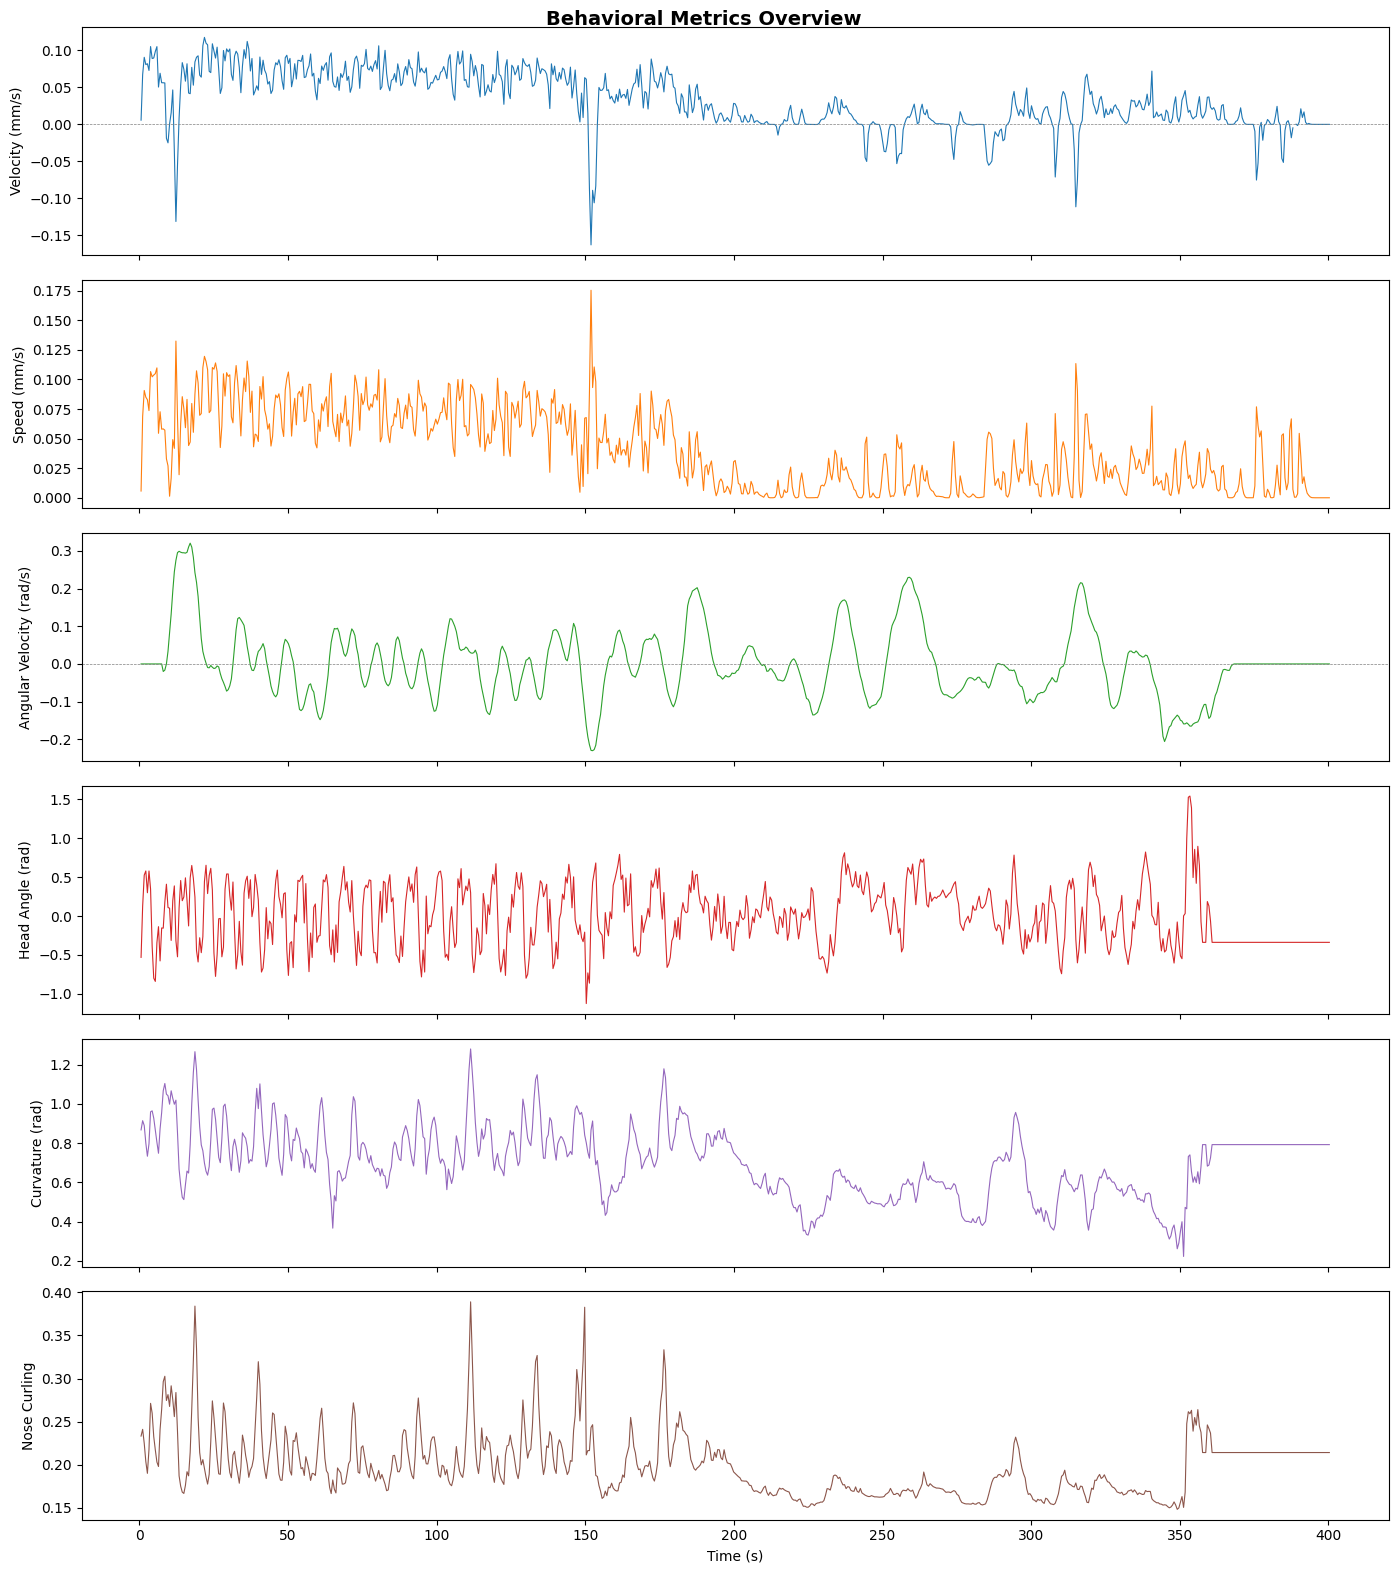

In [ ]:
# ============================================================
# 5B. Behavioral overview — 6-panel figure
# ============================================================
fig, axes = plt.subplots(6, 1, figsize=(14, 16), sharex=True)

t = df['time_s'] if 'time_s' in df.columns else np.arange(len(df)) * 0.533

metrics = [
    ('velocity_stage',   'Velocity (mm/s)',          'C0', True),
    ('speed_stage',      'Speed (mm/s)',             'C1', False),
    ('angular_velocity', 'Angular Velocity (rad/s)', 'C2', True),
    ('head_angle',       'Head Angle (rad)',         'C3', False),
    ('worm_curvature',   'Curvature (rad)',          'C4', False),
    ('nose_curling',     'Nose Curling',             'C5', False),
]

for ax, (col, label, color, zero_line) in zip(axes, metrics):
    if col in df.columns:
        ax.plot(t, df[col], color=color, linewidth=0.8)
        ax.set_ylabel(label)
        if zero_line:
            ax.axhline(0, color='gray', linestyle='--', linewidth=0.5)
    else:
        ax.text(0.5, 0.5, f'{col} not found', transform=ax.transAxes, ha='center')
        ax.set_ylabel(label)

axes[-1].set_xlabel('Time (s)')
plt.tight_layout()
plt.show()

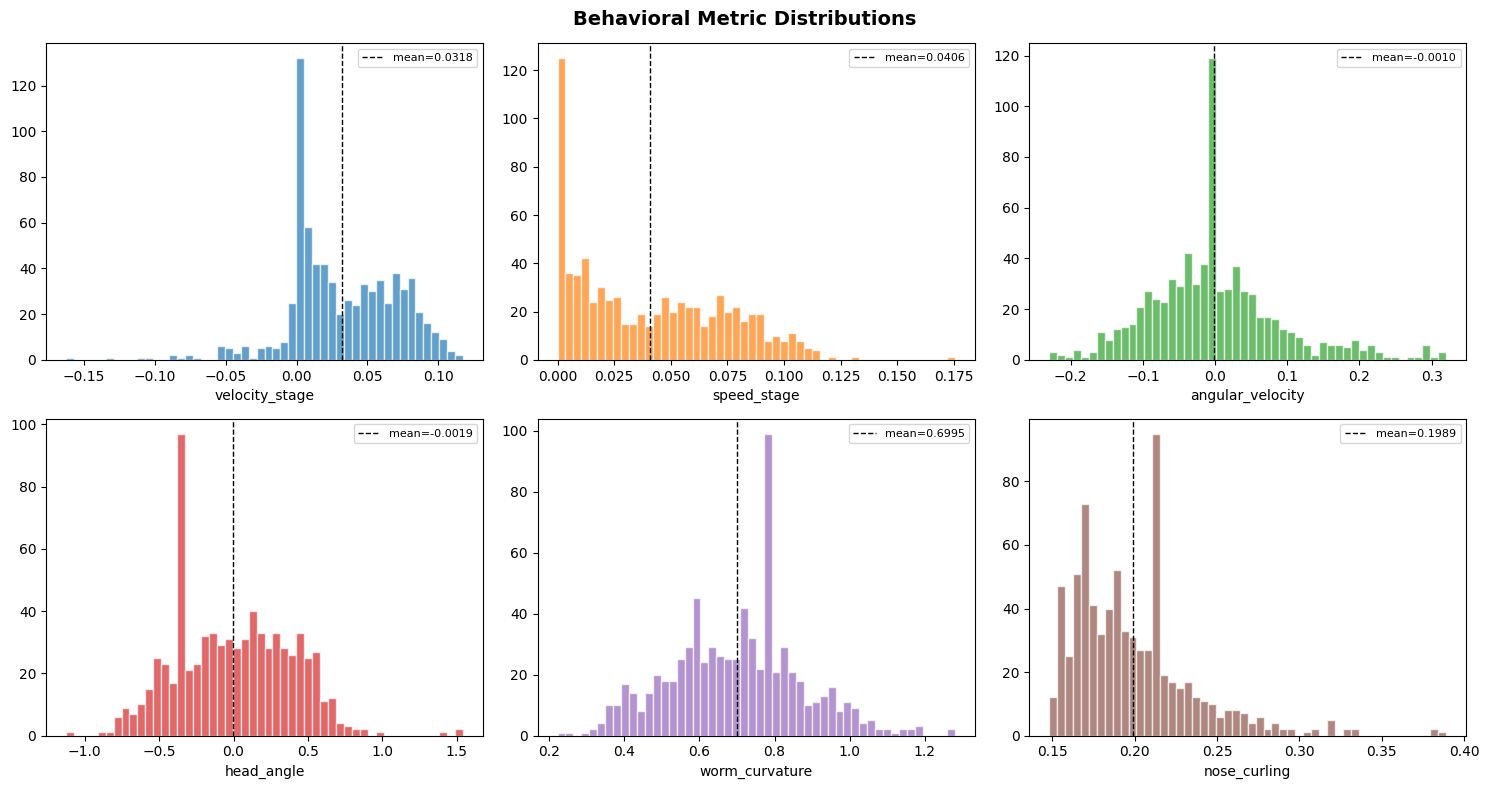

In [ ]:
# ============================================================
# 5C. Behavioral distributions
# ============================================================
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

hist_cols = ['velocity_stage', 'speed_stage', 'angular_velocity',
             'head_angle', 'worm_curvature', 'nose_curling']
colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5']

for ax, col, color in zip(axes.flat, hist_cols, colors):
    if col in df.columns:
        vals = df[col].dropna()
        ax.hist(vals, bins=50, color=color, alpha=0.7, edgecolor='white')
        ax.axvline(vals.mean(), color='k', linestyle='--', linewidth=1,
                   label=f'mean={vals.mean():.4f}')
        ax.set_xlabel(col)
        ax.legend(fontsize=8)
    else:
        ax.text(0.5, 0.5, f'{col} not found', transform=ax.transAxes, ha='center')

plt.tight_layout()
plt.show()

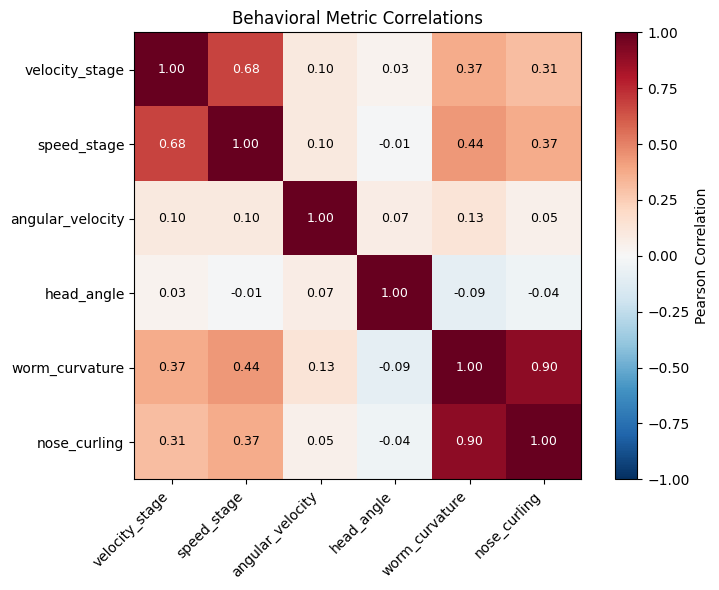

In [11]:
# ============================================================
# 5D. Pairwise correlations between behavioral metrics
# ============================================================
metric_cols = [c for c in ['velocity_stage', 'speed_stage', 'angular_velocity',
                           'head_angle', 'worm_curvature', 'nose_curling']
               if c in df.columns]

corr = df[metric_cols].corr()

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(corr, cmap='RdBu_r', vmin=-1, vmax=1)
ax.set_xticks(range(len(metric_cols)))
ax.set_yticks(range(len(metric_cols)))
ax.set_xticklabels(metric_cols, rotation=45, ha='right')
ax.set_yticklabels(metric_cols)

# Add correlation values
for i in range(len(metric_cols)):
    for j in range(len(metric_cols)):
        ax.text(j, i, f'{corr.iloc[i, j]:.2f}', ha='center', va='center',
                color='white' if abs(corr.iloc[i, j]) > 0.5 else 'black', fontsize=9)

plt.colorbar(im, label='Pearson Correlation')
plt.title('Behavioral Metric Correlations')
plt.tight_layout()
plt.show()

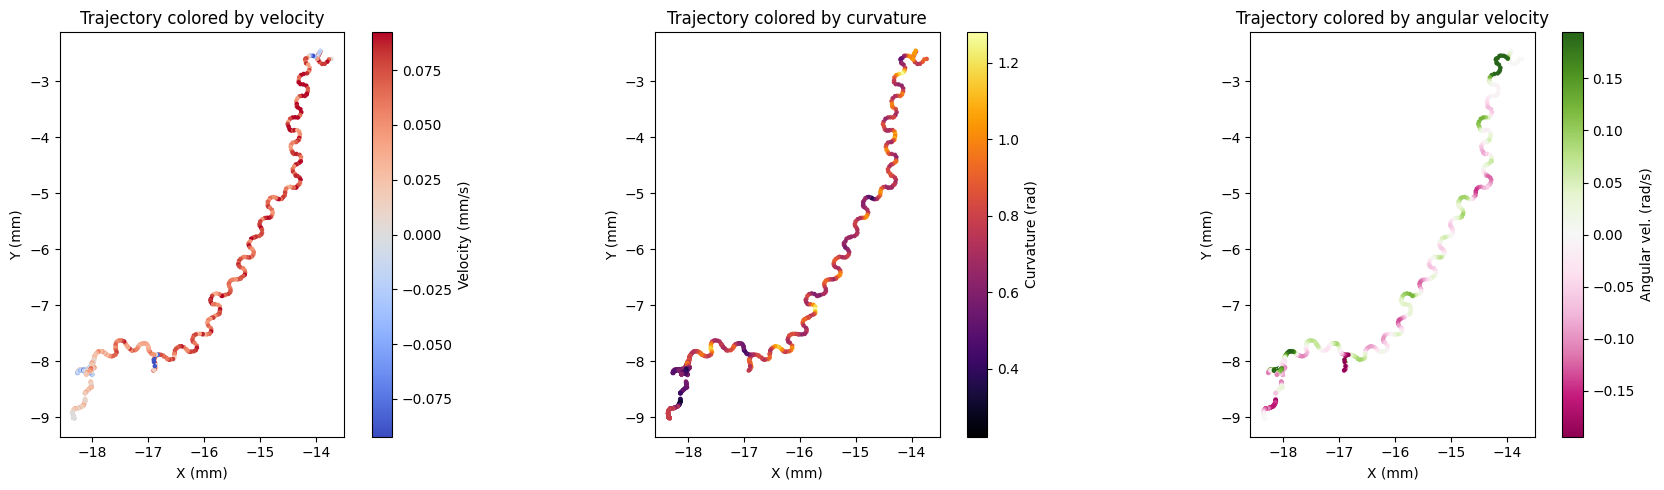

In [13]:
# ============================================================
# 5E. Trajectory colored by behavioral state
# ============================================================
stage_csv = os.path.join(PTH, f'{FN}_stage_aligned.csv')

if os.path.exists(stage_csv):
    stage = np.loadtxt(stage_csv, delimiter=',', skiprows=1)
    x_mm = stage[:len(df), 1] / 10000
    y_mm = stage[:len(df), 2] / 10000

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Colored by velocity
    if 'velocity_stage' in df.columns:
        v = df['velocity_stage'].values[:len(x_mm)]
        vmax = np.nanpercentile(np.abs(v), 95)
        sc = axes[0].scatter(x_mm, y_mm, s=5, c=v, cmap='coolwarm', vmin=-vmax, vmax=vmax)
        plt.colorbar(sc, ax=axes[0], label='Velocity (mm/s)')
        axes[0].set_title('Trajectory colored by velocity')

    # Colored by curvature
    if 'worm_curvature' in df.columns:
        c = df['worm_curvature'].values[:len(x_mm)]
        sc = axes[1].scatter(x_mm, y_mm, s=5, c=c, cmap='inferno')
        plt.colorbar(sc, ax=axes[1], label='Curvature (rad)')
        axes[1].set_title('Trajectory colored by curvature')

    # Colored by angular velocity
    if 'angular_velocity' in df.columns:
        av = df['angular_velocity'].values[:len(x_mm)]
        avmax = np.nanpercentile(np.abs(av), 95)
        sc = axes[2].scatter(x_mm, y_mm, s=5, c=av, cmap='PiYG', vmin=-avmax, vmax=avmax)
        plt.colorbar(sc, ax=axes[2], label='Angular vel. (rad/s)')
        axes[2].set_title('Trajectory colored by angular velocity')

    for ax in axes:
        ax.set_xlabel('X (mm)'); ax.set_ylabel('Y (mm)')
        ax.set_aspect('equal')

    plt.tight_layout()
    plt.show()
else:
    print(f"Stage CSV not found: {stage_csv}")

In [ ]:
# ============================================================
# 5F. Generate aligned NIR video with behavioral annotations
# ============================================================
import cv2
import tifffile

tif_name = f'{FN}_nir_aligned.tif'
tif_path = os.path.join(PTH, tif_name)
out_fn = os.path.join(PTH, f'{FN}_nir_annotated.mp4')

if os.path.exists(tif_path):
    im = tifffile.imread(tif_path)
    nframes, height, width = im.shape
    save_fps = 8
    vol_rate = 1.0 / 0.533

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(out_fn, fourcc, save_fps, (width, height), isColor=True)

    print(f'Saving {nframes} frames at {width}x{height}...')
    for i in range(nframes):
        if i % 100 == 0:
            print(f'  Frame {i}/{nframes}')

        frame = im[i]
        f_max = np.max(frame)
        frame = (frame / f_max * 255).astype(np.uint8) if f_max > 0 else frame.astype(np.uint8)

        # Annotate with time and velocity and if reversal frame
        t_sec = i / vol_rate
        text = f'Vol: {i}  t={t_sec:.1f}s'
        if 'velocity_stage' in df.columns and i < len(df):
            v = df['velocity_stage'].iloc[i]
            text += f'  v={v:.4f} mm/s'
        # if 'all_rev' in df.columns and i < len(df):
        #     is_rev = df['all_rev'].iloc[i]
        #     text += f'  v={v:.4f} mm/s'
        cv2.putText(frame, text, (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255), 1)

        frame_bgr = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
        out.write(frame_bgr)

    out.release()
    print(f'Video saved: {out_fn}')
else:
    print(f'NIR TIF not found: {tif_path}')
    print(f'Run Part 3 (sync + export) first.')

Saving 751 frames at 968x732...
  Frame 0/751
  Frame 100/751
  Frame 200/751
  Frame 300/751
  Frame 400/751
  Frame 500/751
  Frame 600/751
  Frame 700/751
Video saved: C:\Users\munib\POSTDOC\DATA\g5ht-free\20251028\date-20251028_time-1500_strain-ISg5HT_condition-starvedpatch_worm002_nir_annotated.mp4


In [21]:
# ============================================================
# 5G. Summary statistics
# ============================================================
print("=" * 60)
print("BEHAVIORAL SUMMARY")
print("=" * 60)

if 'time_s' in df.columns:
    print(f"Recording duration:   {df['time_s'].iloc[-1]:.1f} s  ({df['time_s'].iloc[-1]/60:.1f} min)")
print(f"Total timepoints:     {len(df)}")
print(f"Volume rate:          ~{1/0.533:.2f} Hz ({0.533:.3f} s/vol)")
print()

summary_cols = ['velocity_stage', 'speed_stage', 'angular_velocity',
                'head_angle', 'worm_curvature', 'nose_curling']
for col in summary_cols:
    if col in df.columns:
        vals = df[col].dropna()
        print(f"{col:25s}  mean={vals.mean():+.5f}  std={vals.std():.5f}  "
              f"range=[{vals.min():.5f}, {vals.max():.5f}]")

if 'rev_times' in df.columns:
    n_rev = (df['rev_times'] > 0).sum()
    print(f"\nReversal timepoints:  {n_rev} / {len(df)} ({n_rev/len(df)*100:.1f}%)")

BEHAVIORAL SUMMARY
Recording duration:   400.3 s  (6.7 min)
Total timepoints:     751
Volume rate:          ~1.88 Hz (0.533 s/vol)

velocity_stage             mean=+0.03180  std=0.03830  range=[-0.16279, 0.11754]
speed_stage                mean=+0.04063  std=0.03335  range=[0.00000, 0.17535]
angular_velocity           mean=-0.00099  std=0.09144  range=[-0.22993, 0.32021]
head_angle                 mean=-0.00186  std=0.38673  range=[-1.12563, 1.54240]
worm_curvature             mean=+0.69949  std=0.17583  range=[0.22189, 1.27965]
nose_curling               mean=+0.19894  std=0.03622  range=[0.14818, 0.38904]

Reversal timepoints:  53 / 751 (7.1%)


---
## Appendix: Behavioral Metrics Reference

This section documents every variable computed by the behavioral pipeline, including the mathematical definitions, source functions, units, and data shapes. Variables exist at two temporal rates:

- **NIR rate** (prefix `nir_`): one value per NIR camera frame (~20 fps, `max_t_nir` frames total)
- **Confocal rate** (no prefix): one value per confocal volume (~0.5 s/vol, `max_t` volumes total)

Confocal-rate variables are produced by averaging the NIR-rate variable over all NIR frames within each confocal volume, via `nir_vec_to_confocal(vec, confocal_to_nir, max_t)`.

---

### A.0 Prerequisite / Structural Variables

| Key | Shape | Description |
|-----|-------|-------------|
| `x_array`, `y_array` | `(max_t_nir, 1001)` | Worm medial-axis spline coordinates at each NIR frame. 1001 equally-spaced points from head (col 1) to tail (col 1001). In UNet pixel coords. |
| `nir_worm_angle` | `(max_t_nir,)` | Overall worm body orientation angle in the lab frame (rad). |
| `eccentricity` | `(max_t_nir,)` | Shape elongation metric (dimensionless). |
| `confocal_to_nir` | `(max_t,)` list of `Vector{Int}` | Maps each confocal volume to its overlapping NIR frame indices. |
| `max_t` | scalar | Number of valid confocal volumes. |
| `max_t_nir` | scalar | Number of valid NIR frames. |
| `t_range` | `1:max_t` | Range of valid confocal timepoints. |
| `segment_end_matrix` | `(max_t_nir,)` list of `Vector{Int}` | Body segment boundary indices into `x_array`/`y_array`. Adjacent boundaries separated by `segment_len=7` pixel-units of arc length. |
| `x_stage`, `y_stage` | `(max_t_nir,)` | Stage position (NaN-imputed). Units: stage units (10,000/mm). |
| `pm_angle` | `(max_t_nir,)` | Pharynx-to-metacorpus angle in lab frame (rad). |
| `x_med`, `y_med` | `(max_t_nir,)` | Centroid-corrected stage position (stage units). |
| `zeroed_x`, `zeroed_y` | `(max_t_nir,)` | Zero-centered position (first frame = origin). |

---

### A.1 Body Angles — `get_body_angles_safe!`

At each NIR frame, the worm is divided into segments by `segment_end_matrix`. For each segment, the direction vector is computed and converted to an angle via $\theta = \text{atan2}(\Delta y, \Delta x)$.

- **`nir_body_angle_absolute`**: Segment angle in lab frame, temporally smoothed (`body_angle_t_lag=40`) then spatially smoothed (`body_angle_pos_lag=2`) via `local_recenter_angle`.
- **`nir_body_angle_all`**: Segment angle **relative to `nir_worm_angle`**, spatially smoothed.
- **`nir_body_angle`**: Same as `nir_body_angle_all` for first `max_pt-1=30` segments, NaN-imputed.

| Key | Shape | Units |
|-----|-------|-------|
| `nir_body_angle` | `(30, max_t_nir)` | rad |
| `nir_body_angle_all` | `(m, max_t_nir)` | rad |
| `nir_body_angle_absolute` | `(m, max_t_nir)` | rad |
| `body_angle` / `body_angle_all` / `body_angle_absolute` | confocal versions | rad |

---

### A.2 Angular Velocity — `get_angular_velocity_safe!`

Head turning rate. Takes the absolute body angle of the first head segment, imputes NaN, then applies a **Savitzky-Golay derivative filter** (window = `filt_len_angvel=150` frames) and multiplies by `FLIR_FPS=20.0` to get rad/s.

| Key | Shape | Units |
|-----|-------|-------|
| `worm_angle` | `(max_t,)` | rad |
| `nir_angular_velocity` | `(max_t_nir,)` | rad/s |
| `angular_velocity` | `(max_t,)` | rad/s |

**Note:** First and last 150 frames are zeroed (insufficient data for the filter window).

---

### A.3 Velocity, Speed & Reversals — `get_velocity_safe!`

#### Stage position filtering
1. `x_med`, `y_med` smoothed via **Group-Sparse Total Variation (GSTV)** denoising: minimizes $\frac{1}{2}\|y - x\|_2^2 + \lambda \Phi(Dx)$ where $\Phi$ is a group-sparse penalty. Params: `v_stage_m_filt=10` (group size), `v_stage_λ_filt=250.0` (regularization).

#### Speed and velocity
2. **Speed** = $\frac{\sqrt{\Delta x^2 + \Delta y^2}}{\Delta t \times 10000}$, where 10000 converts stage units→mm.
3. **Signed velocity** = $\text{speed} \times \cos(\theta_{\text{movement}} - \theta_{\text{pharynx}})$  
   Positive = forward (along pharynx direction). Negative = backward (reversal).

#### Reversal detection
4. Consecutive timepoints where `velocity < rev_v_thresh = -0.005` mm/s, lasting ≥ `rev_len_thresh=2` frames.

| Key | Shape | Units |
|-----|-------|-------|
| `filt_xmed`, `filt_ymed` | `(max_t_nir,)` | stage units |
| `nir_mov_vec_stage` | `(2, max_t_nir)` | stage units |
| `nir_mov_angle_stage` / `mov_angle_stage` | `(max_t_nir,)` / `(max_t,)` | rad |
| `nir_speed_stage` / `speed_stage` | `(max_t_nir,)` / `(max_t,)` | mm/s |
| `nir_velocity_stage` / `velocity_stage` | `(max_t_nir,)` / `(max_t,)` | mm/s |
| `reversal_events` | list of ranges | confocal timepoint ranges |
| `all_rev` | `Vector{Int}` | all reversal timepoints |
| `rev_times` | `(max_t,)` | duration of current reversal (frames, 0 if not reversing) |

---

### A.4 Curvature — `get_curvature_variables_safe!`

#### Whole-body curvature
- **`worm_curvature`** (non-directional): $\sigma(\text{body angles})$ — standard deviation of the body angles across all segments.
- **`ventral_worm_curvature`** (directional): $(\theta_1 - \theta_{\text{min\_len}}) / N$ — captures consistent bending to one side.

#### Head & nose angles
- **`head_angle`**: Angle between segment vectors at `head_pts=[1,5,8]`. Measures head bending relative to mid-body.
- **`nose_angle`**: Same using `nose_pts=[1,2,3]`. Measures tip-of-nose bending.

Both computed by: vectors $\vec{v_1} = (b \to c)$, $\vec{v_2} = (a \to b)$, then $\theta = \text{angle}(\vec{v_1}) - \text{angle}(\vec{v_2})$, negated.

| Key | Shape | Units |
|-----|-------|-------|
| `worm_curvature` | `(max_t,)` | rad (dimensionless) |
| `ventral_worm_curvature` | `(max_t,)` | rad (dimensionless) |
| `nir_head_angle` / `head_angle` | NIR / confocal | rad |
| `nir_nose_angle` / `nose_angle` | NIR / confocal | rad |

---

### A.5 Nose Curling — `get_nose_curling_safe!`

Detects self-intersection of the worm head. For the first body segment and every other segment $j$:

$$r_{1,j} = \frac{d_{\text{Euclid}}(\text{seg}_1, \text{seg}_j)}{j - 1}$$

Returns $1 / \min(r_{1,j})$. Values ~1 = straight; ~0 = self-intersecting.

| Key | Shape | Units |
|-----|-------|-------|
| `nir_nose_curling` | `(max_t_nir,)` | dimensionless |
| `nose_curling` | `(max_t,)` | dimensionless |

---

### A.6 Parameters Reference

| Parameter | Value | Used by |
|-----------|-------|---------|  
| `num_center_pts` | 1000 | `get_segment_end_matrix` |
| `segment_len` | 7 | `get_segment_end_matrix` |
| `max_pt` | 31 | Body angles, nose curling |
| `body_angle_t_lag` | 40 | `get_body_angles_safe!` |
| `body_angle_pos_lag` | 2 | `get_body_angles_safe!` |
| `head_pts` | [1, 5, 8] | `get_curvature_variables_safe!` |
| `nose_pts` | [1, 2, 3] | `get_curvature_variables_safe!` |
| `filt_len_angvel` | 150 | `get_angular_velocity_safe!` |
| `FLIR_FPS` | 20.0 | All velocity/speed computations |
| `v_stage_m_filt` | 10 | GSTV group size |
| `v_stage_λ_filt` | 250.0 | GSTV regularization |
| `rev_len_thresh` | 2 | Reversal min duration (frames) |
| `rev_v_thresh` | -0.005 | Reversal velocity threshold (mm/s) |

### A.7 Unit Conversions

| From | To | Formula |
|------|----|---------|  
| Stage units | mm | ÷ 10,000 |
| NIR pixels | mm | × (1/791) |
| NIR frames | seconds | ÷ 20 |
| Confocal volumes | seconds | × ~0.533 |

### A.8 Complete `data_dict` Key Index

| Source | Keys |
|--------|------|
| Spline | `x_array`, `y_array`, `nir_worm_angle`, `eccentricity`, `is_omega`, `pts_order_dict`, `med_axis_dict`, `worm_thickness` |
| `add_nonspline_data!` | `confocal_to_nir`, `max_t_nir`, `max_t`, `t_range`, `x_stage`, `y_stage`, `pm_angle`, `x_med`, `y_med` |
| Setup | `segment_end_matrix`, `x_stage_confocal`, `y_stage_confocal`, `zeroed_x`, `zeroed_y`, `zeroed_x_confocal`, `zeroed_y_confocal` |
| `get_body_angles_safe!` | `nir_body_angle`, `nir_body_angle_all`, `nir_body_angle_absolute`, `body_angle`, `body_angle_all`, `body_angle_absolute` |
| `get_angular_velocity_safe!` | `worm_angle`, `nir_angular_velocity`, `angular_velocity` |
| `get_velocity_safe!` | `filt_xmed`, `filt_ymed`, `nir_mov_vec_stage`, `mov_vec_stage`, `nir_mov_angle_stage`, `mov_angle_stage`, `nir_speed_stage`, `speed_stage`, `nir_velocity_stage`, `velocity_stage`, `reversal_events`, `all_rev`, `rev_times` |
| `get_curvature_variables_safe!` | `worm_curvature`, `ventral_worm_curvature`, `nir_head_angle`, `nir_nose_angle`, `head_angle`, `nose_angle` |
| `get_nose_curling_safe!` | `nir_nose_curling`, `nose_curling` |